# QAOA for Portfolio Optimization, Toy Example
In this notebook a small portfolio optimization problem is solved using QAOA. We incorporate the fixed budget constraint using two different methods, namely the penalty method and the XY-mixer method. The quantum circuit used is shown for both methods and the approximation ratio for depth = 1 is computed for the two methods.

# Import neceassry modules

In [1]:
from qaoa import QAOA, problems, mixers, initialstates

In [2]:
from asset_loader import AssetData

import os
import sys
sys.path.append('../')
from plotroutines import *

import itertools

# Creating problem instance

/home/franzf/OpenQuantumComputing/QAOA/examples/PortfolioOptimization/asset_loader.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=-30)


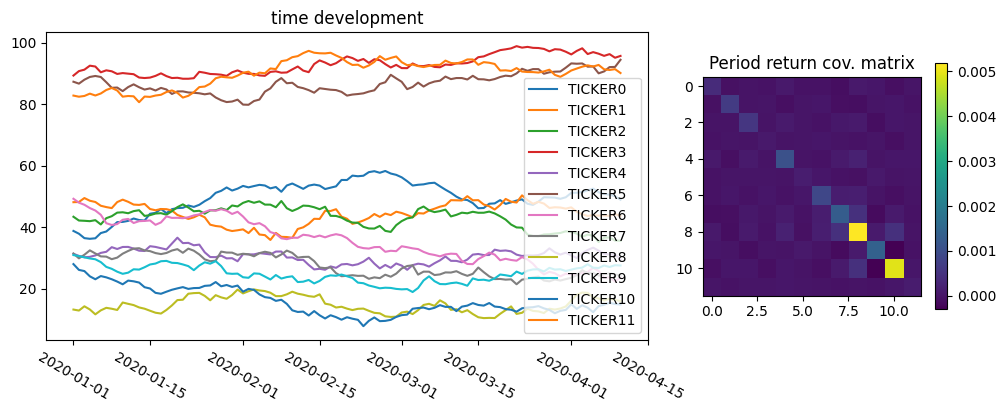

In [3]:
number_of_assets = 12
budget = 4

filename = os.path.join("data", "qiskit_finance_seeds.npz") #filename of file containing time series of 
                                                            #non-crashing stocks.
seeds = np.load(filename)
assets = AssetData(number_of_assets, seed=seeds[str(number_of_assets)][132])

assets.plotAssets()

# Creating QAOA instances for both methods
Below we create a QAOA instance for both the penalty method and for the XY-mixer method.
The gamma_scale parameter is used to adjust the search range for the gamma parameter. 

For information about the scale parameter see Sebastian Brandhofer et al. “Benchmarking the performance of portfolio optimization with QAOA”. In: Quantum Information Processing 22.1 (2023), page 25-26)
or Zichang He et al. Alignment between Initial State and Mixer Improves QAOA Performance for 
Constrained Portfolio Optimization page 7 (2023)

In [4]:
gamma_scale = 5000 #Adjusts the search range for the gamma parameter 

qaoa_penalty = QAOA(
    initialstate=initialstates.Plus(),
    problem=problems.PortfolioOptimization(
        risk=.5*gamma_scale,
        budget=budget,
        cov_matrix=assets.cov_matrix,
        exp_return=assets.exp_return*gamma_scale,
        penalty = 4*gamma_scale,
    ),
    mixer=mixers.X()
)

qaoa_XYmixer_chain = QAOA(
    initialstate=initialstates.DickeState(budget),
    problem=problems.PortfolioOptimization(
        risk=.5*gamma_scale,
        budget=budget,
        cov_matrix=assets.cov_matrix,
        exp_return=assets.exp_return*gamma_scale
    ),
    mixer=mixers.XY(method="chain")
)

qaoa_XYmixer_ring = QAOA(
    initialstate=initialstates.DickeState(budget),
    problem=problems.PortfolioOptimization(
        risk=.5*gamma_scale,
        budget=budget,
        cov_matrix=assets.cov_matrix,
        exp_return=assets.exp_return*gamma_scale
    ),
    mixer=mixers.XY(method="ring")
)

qaoa_Grover = QAOA(
    initialstate=initialstates.DickeState(budget),
    problem=problems.PortfolioOptimization(
        risk=.5*gamma_scale,
        budget=budget,
        cov_matrix=assets.cov_matrix,
        exp_return=assets.exp_return*gamma_scale
    ),
    mixer=mixers.Grover(budget)
)

# Sample and plot the cost landscape for penalty method
The cost landscape is sampled using angles $\gamma, \beta$ $\in$ $[0, \frac{\pi}{2}]$. The cost landscape is periodic with period $\frac{\pi}{2}$ in $\beta$.

2023-09-27 12:09:10 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
1 0
2023-09-27 12:09:10 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-09-27 12:09:10 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-09-27 12:09:10 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-09-27 12:09:11 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-09-27 12:09:11 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


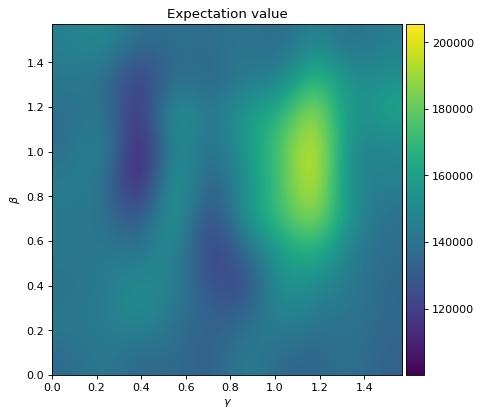

In [5]:
qaoa_penalty.sample_cost_landscape(angles={"gamma": [0,np.pi/2,10], "beta": [0,np.pi/2,10]})
plot_E(qaoa_penalty)

# Sample and plot the cost landscape for XY-mixer method
The cost landscape is sampled using angles $\gamma \in [0, \frac{\pi}{2}]$ and $\beta \in [0, 2\pi]$. In the plot a maximum and minimun of the cost function is seen. The cost landscape is periodic with period $2\pi$ in $\beta$ (different than for the penalty mixer)

2023-09-27 12:09:12 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
1 0
2023-09-27 12:09:12 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-09-27 12:09:12 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-09-27 12:09:12 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-09-27 12:09:13 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-09-27 12:09:13 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


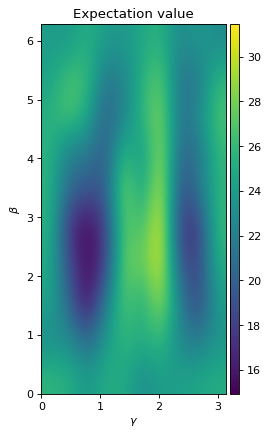

In [6]:
qaoa_XYmixer_chain.sample_cost_landscape(angles={"gamma": [0,np.pi,10], "beta": [0,2*np.pi,10]})
plot_E(qaoa_XYmixer_chain)

2023-09-27 12:09:13 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
1 0
2023-09-27 12:09:13 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-09-27 12:09:13 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-09-27 12:09:14 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-09-27 12:09:15 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-09-27 12:09:15 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


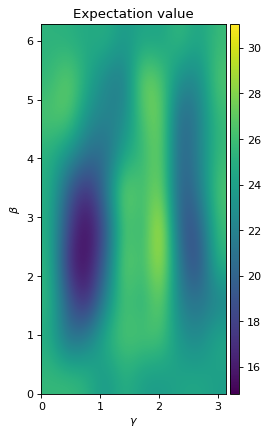

In [7]:
qaoa_XYmixer_ring.sample_cost_landscape(angles={"gamma": [0,np.pi,10], "beta": [0,2*np.pi,10]})
plot_E(qaoa_XYmixer_ring)

2023-09-27 12:09:15 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
1 0
2023-09-27 12:09:15 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-09-27 12:09:15 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-09-27 12:09:15 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-09-27 12:09:17 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-09-27 12:09:17 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


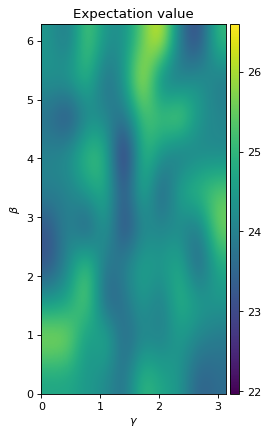

In [8]:
qaoa_Grover.sample_cost_landscape(angles={"gamma": [0,np.pi,10], "beta": [0,2*np.pi,10]})
plot_E(qaoa_Grover)

# Search for the best parameters at depth = 1 and plot histogram for both methods
The values for the parameters $\gamma$ and $\beta$ are found by the optimizer, and the circuit is then measured 2048 times. The measurement outcome is seen in the histogram below. One can see that all the measruement outcomes (pink) for XY-mixer method is in the feasible subspace, while for the penalty method some measured strings are infeasible.

In [9]:
maxdepth=10
qaoa_penalty.optimize(depth=maxdepth)
qaoa_XYmixer_chain.optimize(depth=maxdepth)
qaoa_XYmixer_ring.optimize(depth=maxdepth)
qaoa_Grover.optimize(depth=maxdepth)

2023-09-27 12:09:17 [info     ] cost(depth 1 = 41193.05030296022 file=qaoa.qaoa func=optimize
2023-09-27 12:09:19 [info     ] cost(depth 2 = 125036.58712601809 file=qaoa.qaoa func=optimize
2023-09-27 12:09:21 [info     ] cost(depth 3 = 165480.0129241606 file=qaoa.qaoa func=optimize
2023-09-27 12:09:25 [info     ] cost(depth 4 = 138746.66700779134 file=qaoa.qaoa func=optimize
2023-09-27 12:09:30 [info     ] cost(depth 5 = 132244.23409625812 file=qaoa.qaoa func=optimize
2023-09-27 12:09:37 [info     ] cost(depth 6 = 133592.28205335676 file=qaoa.qaoa func=optimize
2023-09-27 12:09:46 [info     ] cost(depth 7 = 139119.74163080548 file=qaoa.qaoa func=optimize
2023-09-27 12:09:58 [info     ] cost(depth 8 = 135702.9009737443 file=qaoa.qaoa func=optimize
2023-09-27 12:10:12 [info     ] cost(depth 9 = 132263.28066983577 file=qaoa.qaoa func=optimize
2023-09-27 12:10:28 [info     ] cost(depth 10 = 137966.85275368497 file=qaoa.qaoa func=optimize
2023-09-27 12:10:30 [info     ] cost(depth 1 = 14.11

In [10]:
min_cost, max_cost = qaoa_penalty.problem.computeMinMaxCosts()
min_cost, max_cost

(-29.191609262430575, 92.1472431079601)

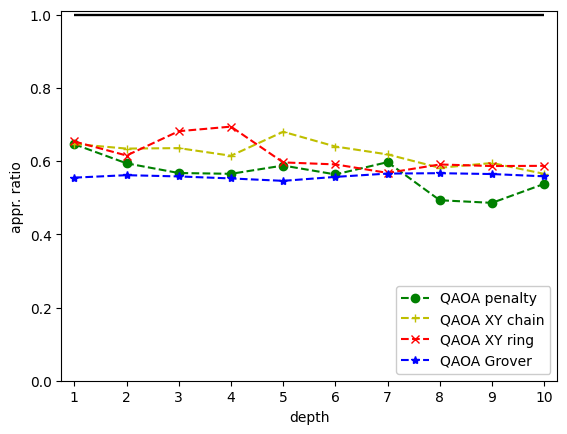

In [11]:
shots=1024
fig=pl.figure()
plot_Exp(qaoa_penalty, maxdepth, mincost=min_cost, maxcost=max_cost, label="QAOA penalty", style="o--g",fig=fig, shots=shots)
plot_Exp(qaoa_XYmixer_chain, maxdepth, mincost=min_cost, maxcost=max_cost, label="QAOA XY chain", style="+--y",fig=fig, shots=shots)
plot_Exp(qaoa_XYmixer_ring, maxdepth, mincost=min_cost, maxcost=max_cost, label="QAOA XY ring", style="x--r",fig=fig, shots=shots)
plot_Exp(qaoa_Grover, maxdepth, mincost=min_cost, maxcost=max_cost, label="QAOA Grover", style="*--b",fig=fig, shots=shots)

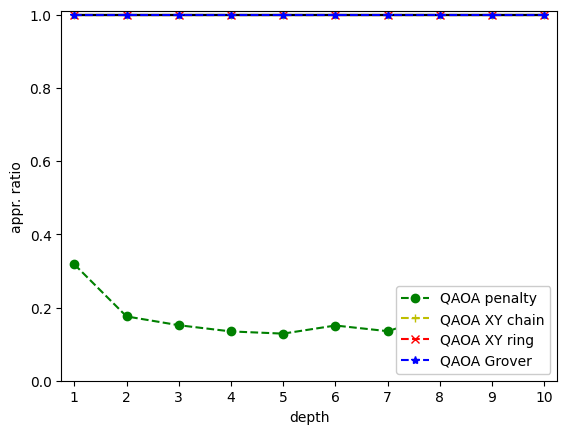

In [12]:
fig=pl.figure()
plot_successprob(qaoa_penalty, maxdepth, mincost=min_cost, maxcost=max_cost, label="QAOA penalty", style="o--g",fig=fig)
plot_successprob(qaoa_XYmixer_chain, maxdepth, mincost=min_cost, maxcost=max_cost, label="QAOA XY chain", style="+--y",fig=fig)
plot_successprob(qaoa_XYmixer_ring, maxdepth, mincost=min_cost, maxcost=max_cost, label="QAOA XY ring", style="x--r",fig=fig)
plot_successprob(qaoa_Grover, maxdepth, mincost=min_cost, maxcost=max_cost, label="QAOA Grover", style="*--b",fig=fig)